In [1]:
import pandas as pd
import os
from sklearn.decomposition import PCA
from sklearn.feature_selection import VarianceThreshold
import seaborn as sns
import matplotlib.pyplot as plt
import pydeseq2 as deseq2
from pydeseq2.dds import DeseqDataSet
from pydeseq2.ds import DeseqStats
from pydeseq2.preprocessing import deseq2_norm
from custom_functions import *

save_format = "svg"

# Load data

## Bulk gastruloid
For this analysis, we will only retain the samples from the 72h and the initial condition at 48h, immediately before Chiron treatment.

In [2]:
#Counts
df_n2b27 = pd.read_csv("data/n2b27_counts.csv",index_col=0)
df_n2b27 = df_n2b27.loc[:,~df_n2b27.columns.duplicated()].copy() #Remove potentially duplicated genes names (very few and irrelevant genes are duplicated)
df_n2b27 = df_n2b27.loc[~(df_n2b27==0).all(axis=1)].T

In [3]:
#Metadata
meta = pd.read_csv("data/n2b27_metadata.csv",index_col=0)

In [4]:
# Marker genes
#marker_genes = pd.read_csv("marker_genes.csv",header=None).values[:,0]

# Preprocessing and QC

**DATASET EXPLORATION**

In [5]:
print(f"Samples in dataset: {df_n2b27.shape[0]}")
print(f"Genes in dataset: {df_n2b27.shape[1]}")

Samples in dataset: 11
Genes in dataset: 34090


**LIBRARY SIZES**

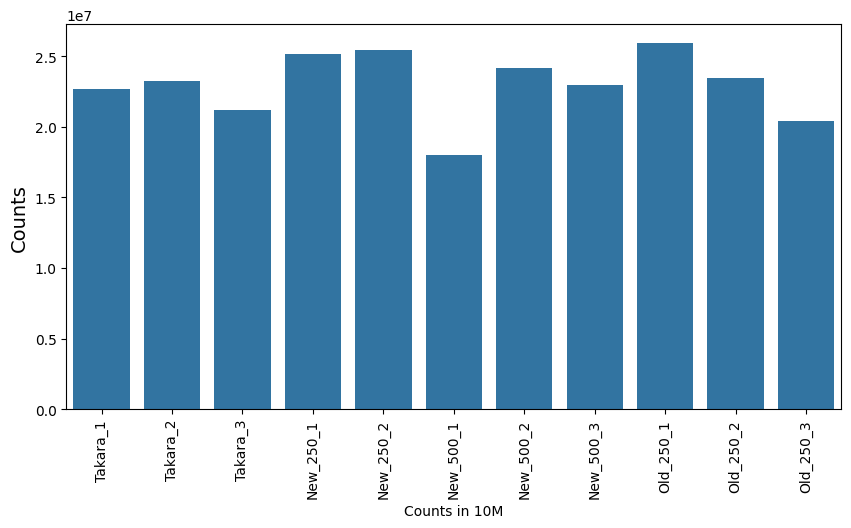

In [6]:
fig,ax=plt.subplots(1,1,figsize=(10,5))
sns.barplot(df_n2b27, x=df_n2b27.index, y=df_n2b27.sum(axis=1),ax=ax)

plt.xticks(rotation=90)
plt.xlabel('Counts in 10M')
plt.ylabel('Counts', size=14)

# create result folder
plt.savefig(f"results/bulk_library_sizes.{save_format}")

**LOGCOUNTS DISTRIBUTION**

In [7]:
#LOGSCALING
log_df=np.log1p(df_n2b27)

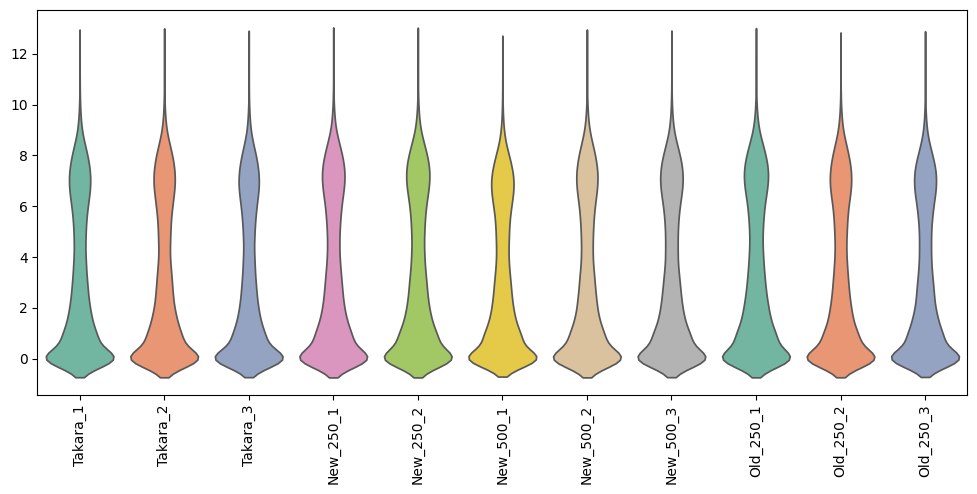

In [8]:
fig,ax=plt.subplots(1,1,figsize=(12,5))

sns.violinplot(log_df.T, palette='Set2',inner=None,ax=ax)
plt.xticks(rotation=90)

plt.savefig(f"results/bulk_logcounts_distribution.{save_format}")

**NORMALIZED COUNTS**

Size factor normalization by median of ratios method

In [9]:
# run deseq2_norm fucntion
dds_norm=deseq2_norm(df_n2b27)

dds_norm[0].T.to_csv(f"data/normalized_counts.csv")

# Analysis

## Construct DESeq2 object

In [10]:
dds = DeseqDataSet(
    counts=df_n2b27.values,
    metadata=meta,
    design_factors="Condition",
    refit_cooks=True
)

/home/paupascualmas/.local/lib/python3.10/site-packages/pydeseq2/dds.py:257: UserWarning: Some factor levels in the design contain underscores ('_').
                    They will be converted to hyphens ('-').
  self.obsm["design_matrix"] = build_design_matrix(


## Variance Stabilizing Transformation (VST)

We scale the data normalizing the sum of total counts and producing and scaling to log1p.

In [11]:
# run vst algorithm
# transformed counts are stored in .layers
dds.vst()

Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 2.85 seconds.

Fitting dispersion trend curve...
... done in 0.67 seconds.



In [12]:
# create df with transformed counts
df1= pd.DataFrame(data=dds.layers['vst_counts'],    
             index=dds.obs.Sample,    
            columns=df_n2b27.columns.values)

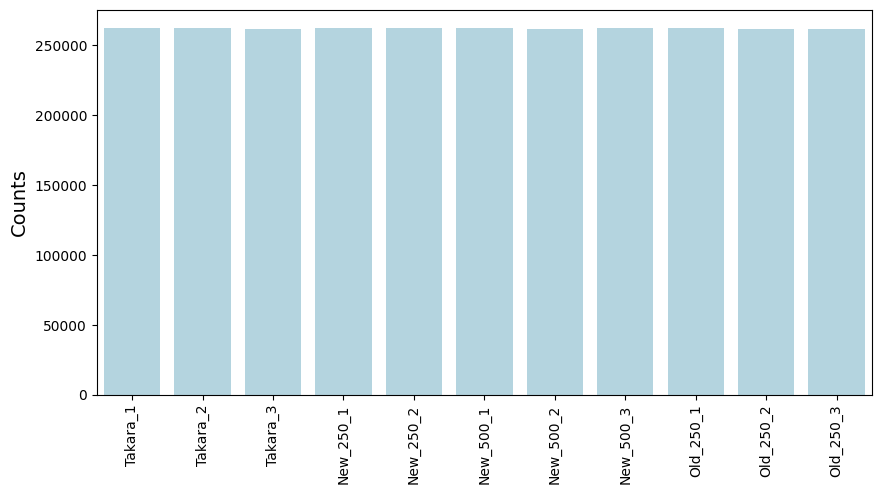

In [13]:
fig,ax=plt.subplots(1,1,figsize=(10,5))
sns.barplot(df1, x=df1.index, y=df1.sum(axis=1),ax=ax, color='lightblue')

plt.xticks(rotation=90)
plt.ylabel('Counts', size=14)
plt.xlabel('')
# create result folder
plt.savefig(f"results/bulk_library_sizes_sizefactoring.{save_format}")

## Feature selection

We use a simple variance threshold to choose the most varying genes.

Free parameters: **threshold**

In [14]:
fs = VarianceThreshold(threshold=0.05)
fs.fit(df1.values)
l1 = fs.get_feature_names_out()
l = [int(i[1:]) for i in l1]

print(f"Genes retained: {len(l)}")

Genes retained: 912


## PCA

<Axes: >

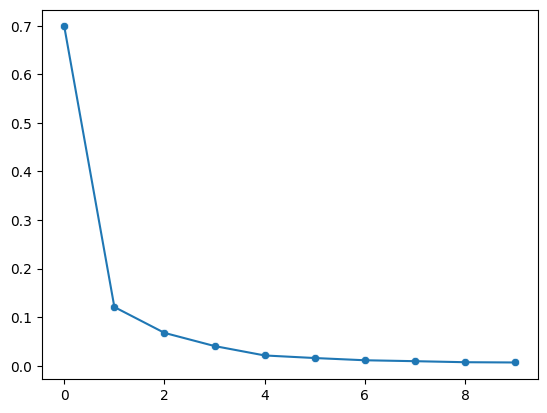

In [15]:
df1_fs = pd.DataFrame(fs.transform(df1.values),index=df1.index,columns=df1.columns.values[l])
pca = PCA(n_components=len(df_n2b27.index)-1)
pca.fit(df1_fs.values)

sns.lineplot(x=np.arange(0,pca.n_components),y=pca.explained_variance_ratio_)
sns.scatterplot(x=np.arange(0,pca.n_components),y=pca.explained_variance_ratio_)

In [16]:
names = df1.columns.values[[int(i[1:]) for i in fs.get_feature_names_out()]]
df1_fs = pd.DataFrame(fs.transform(df1.values),index=df1.index,columns=names)
pca = PCA(n_components=min(4,df1.shape[0]-1))
pca.fit(fs.transform(df1.values));

In [17]:
x = pca.transform(fs.transform(df1.values))

dds.obs['PC1']=x[:,0]
dds.obs['PC2']=x[:,1]

### Representation

Show the PCA components and the Pijuan-Sala projection. The PCA captures time evolution.

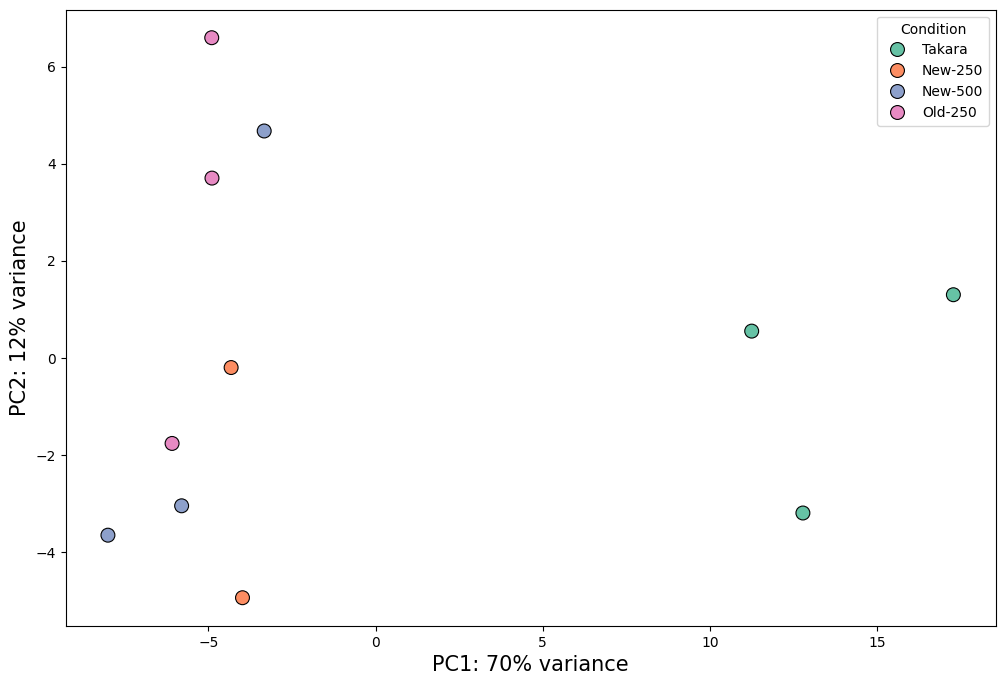

In [18]:
fig,ax=plt.subplots(1,1,figsize=(12,8))
sns.scatterplot(dds.obs,x='PC1', y='PC2', s=100, edgecolor='black',hue='Condition', ax=ax, palette='Set2')

# axes
plt.xlabel(f'PC1: {int(np.round(pca.explained_variance_ratio_[0]*100,decimals=0))}% variance', fontsize=15)
plt.ylabel(f'PC2: {int(np.round(pca.explained_variance_ratio_[1]*100,decimals=0))}% variance', fontsize=15)


plt.savefig(f"results/bulk_analysis_pca_scatterplot.{save_format}",bbox_inches="tight",transparent=True)

### Loadings

This shows that buttom-left to up-right is capturing changes in genes like (T, Wnt3a, etc.) and up-left to bottom-right capturing expressioon of genes like (Hox-family).

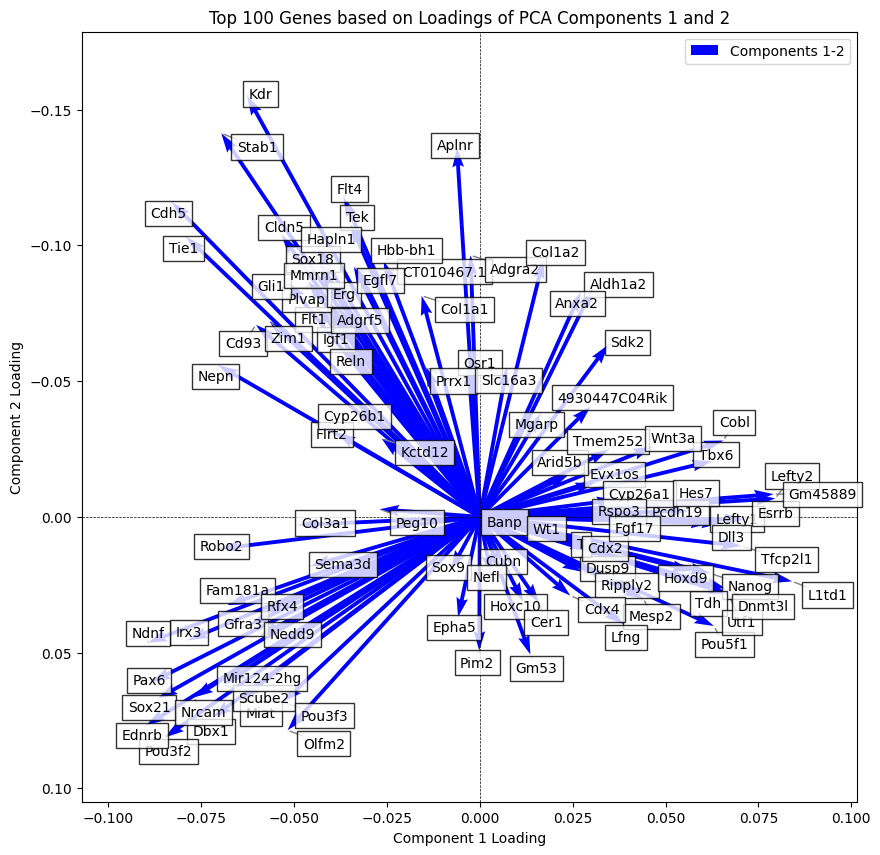

In [20]:
fig, ax = plt.subplots(figsize=(10,10))

plot_loadings_components(pca,0,1,df1_fs.columns.values,100,ax)

#ax.invert_xaxis()
ax.invert_yaxis()

plt.savefig(f"results/bulk_analysis_pca_loadings.{save_format}",bbox_inches="tight",transparent=True)

# HEATMAPS

In [55]:
m1=pd.read_excel('markers.xlsx', sheet_name='markers_1', header=None)[0].tolist()
m2=pd.read_excel('markers.xlsx', sheet_name='markers_2',header=None)[0].tolist()
m3=pd.read_excel('markers.xlsx', sheet_name='markers_3',header=None)[0].tolist()

# 1st

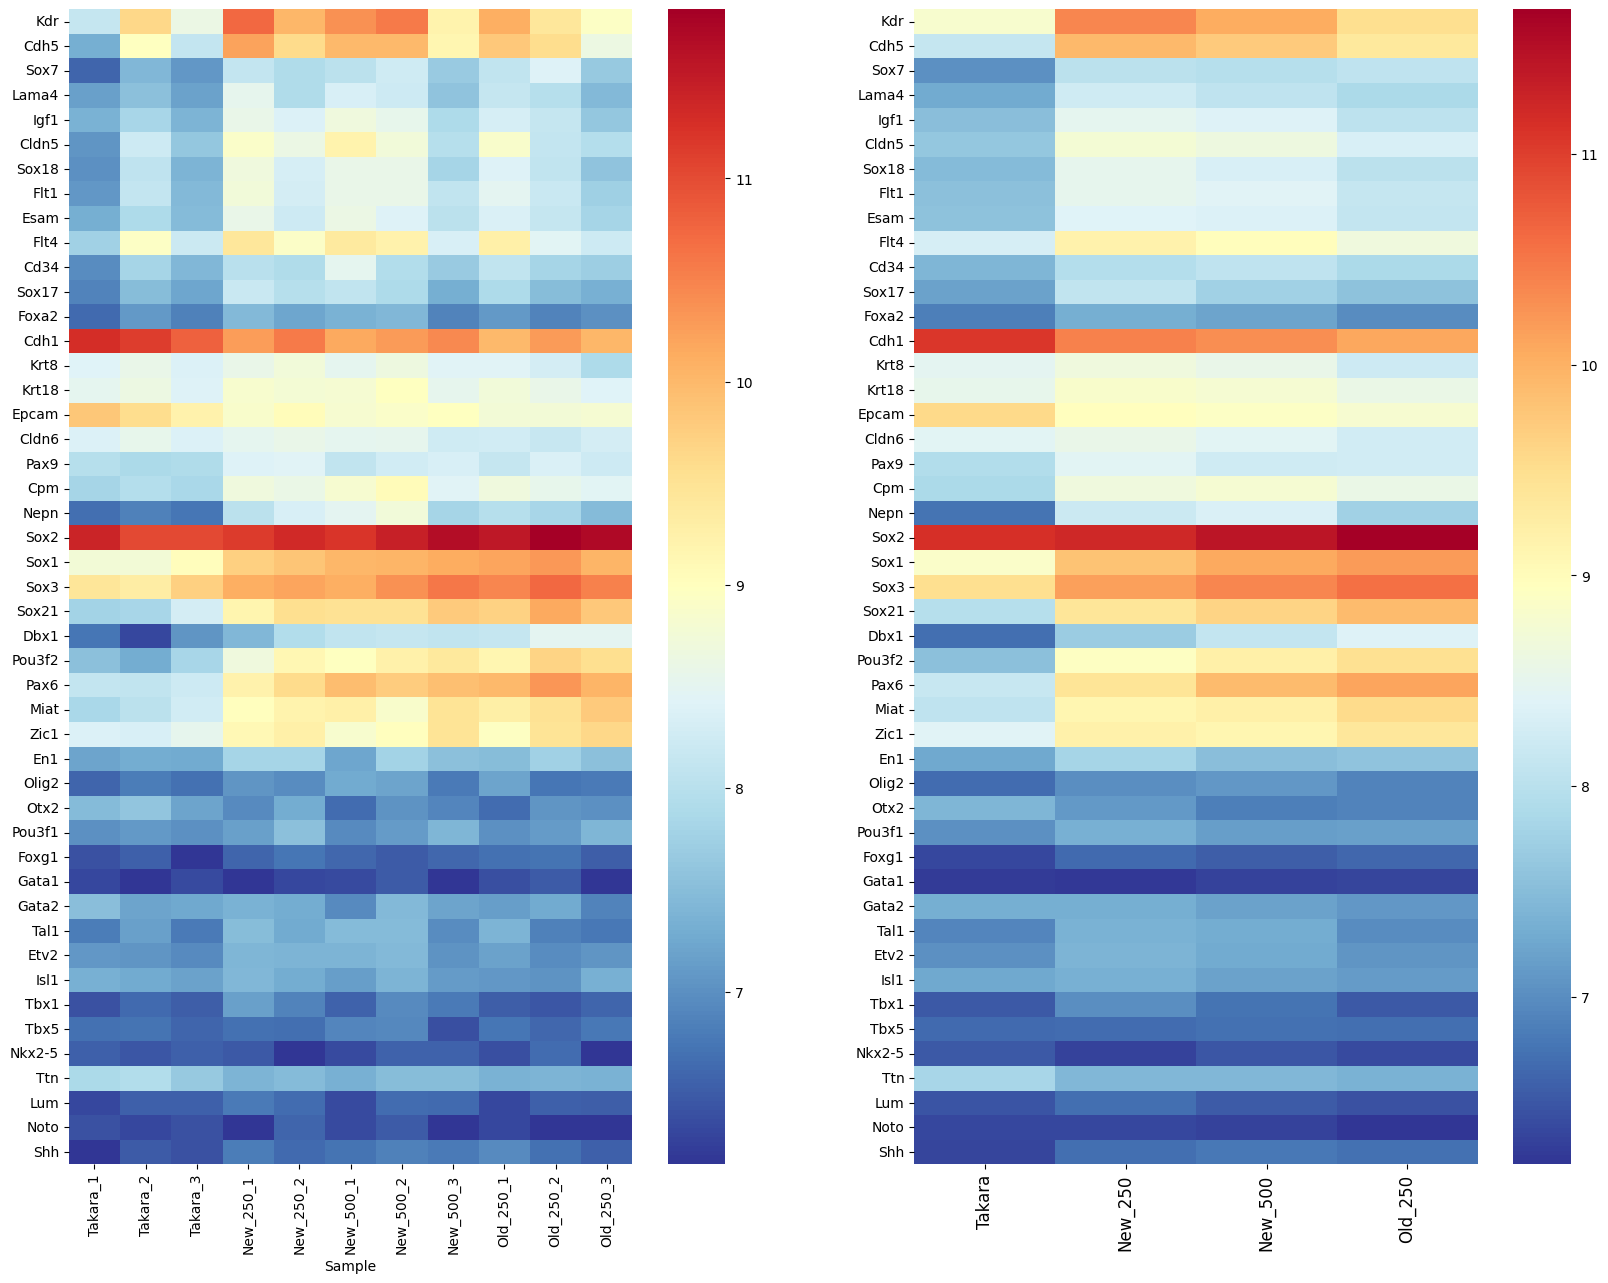

In [110]:
fig,ax=plt.subplots(1,2, figsize=(20,15))

# mean for condition
df1_mean=df1.loc[:,m1].groupby([x[:-2] for x in df1.index.values]).mean().T
df1_mean=df1_mean[['Takara','New_250','New_500','Old_250']]

# plots
sns.heatmap(df1.loc[:,m1].T, ax=ax[0],cmap='RdYlBu_r')
sns.heatmap(df1_mean, ax=ax[1],cmap='RdYlBu_r')

ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation = 90, fontsize = 12)

plt.savefig(f'results/heatmap1.{save_format}')


# 2nd

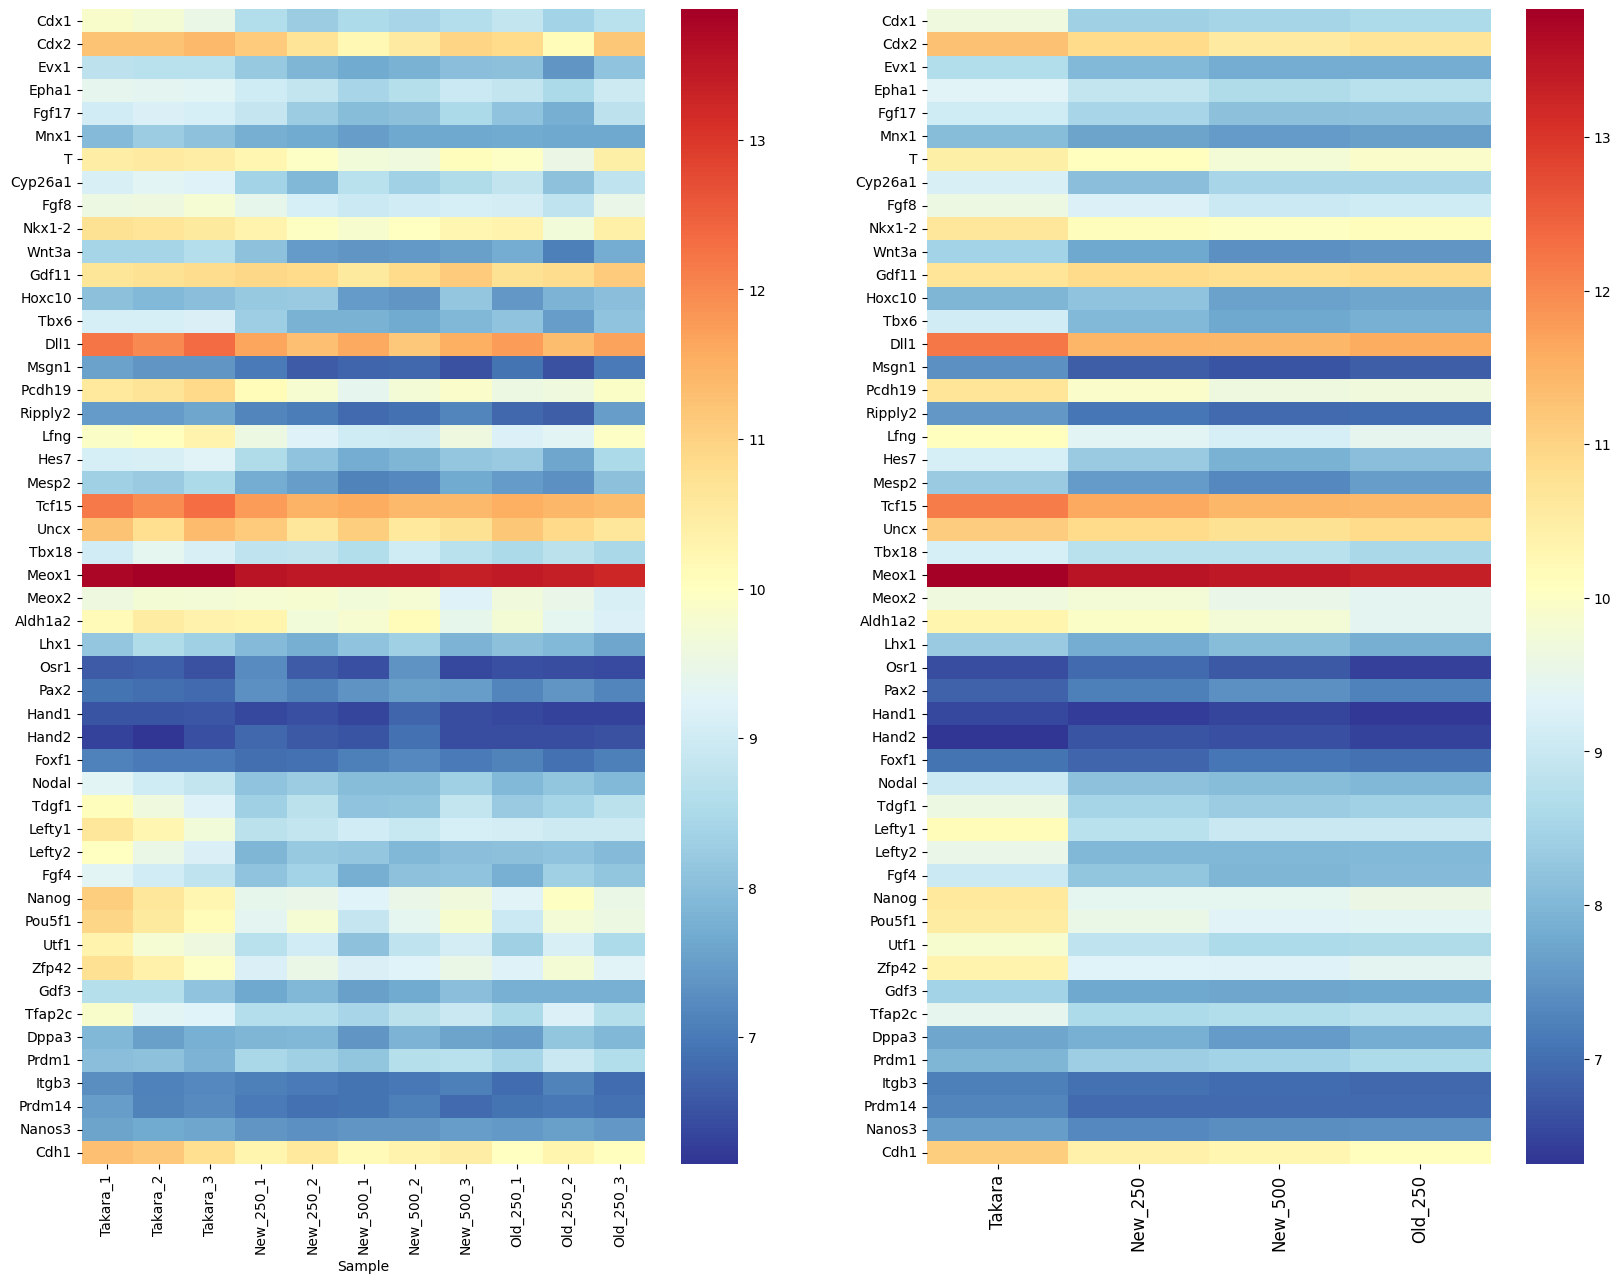

In [111]:
fig,ax=plt.subplots(1,2, figsize=(20,15))

# mean for condition
df1_mean=df1.loc[:,m2].groupby([x[:-2] for x in df1.index.values]).mean().T
df1_mean=df1_mean[['Takara','New_250','New_500','Old_250']]

# plots
sns.heatmap(df1.loc[:,m2].T, ax=ax[0],cmap='RdYlBu_r')
sns.heatmap(df1_mean, ax=ax[1],cmap='RdYlBu_r')

ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation = 90, fontsize = 12)

plt.savefig(f'results/heatmap2.{save_format}')


# 3rd

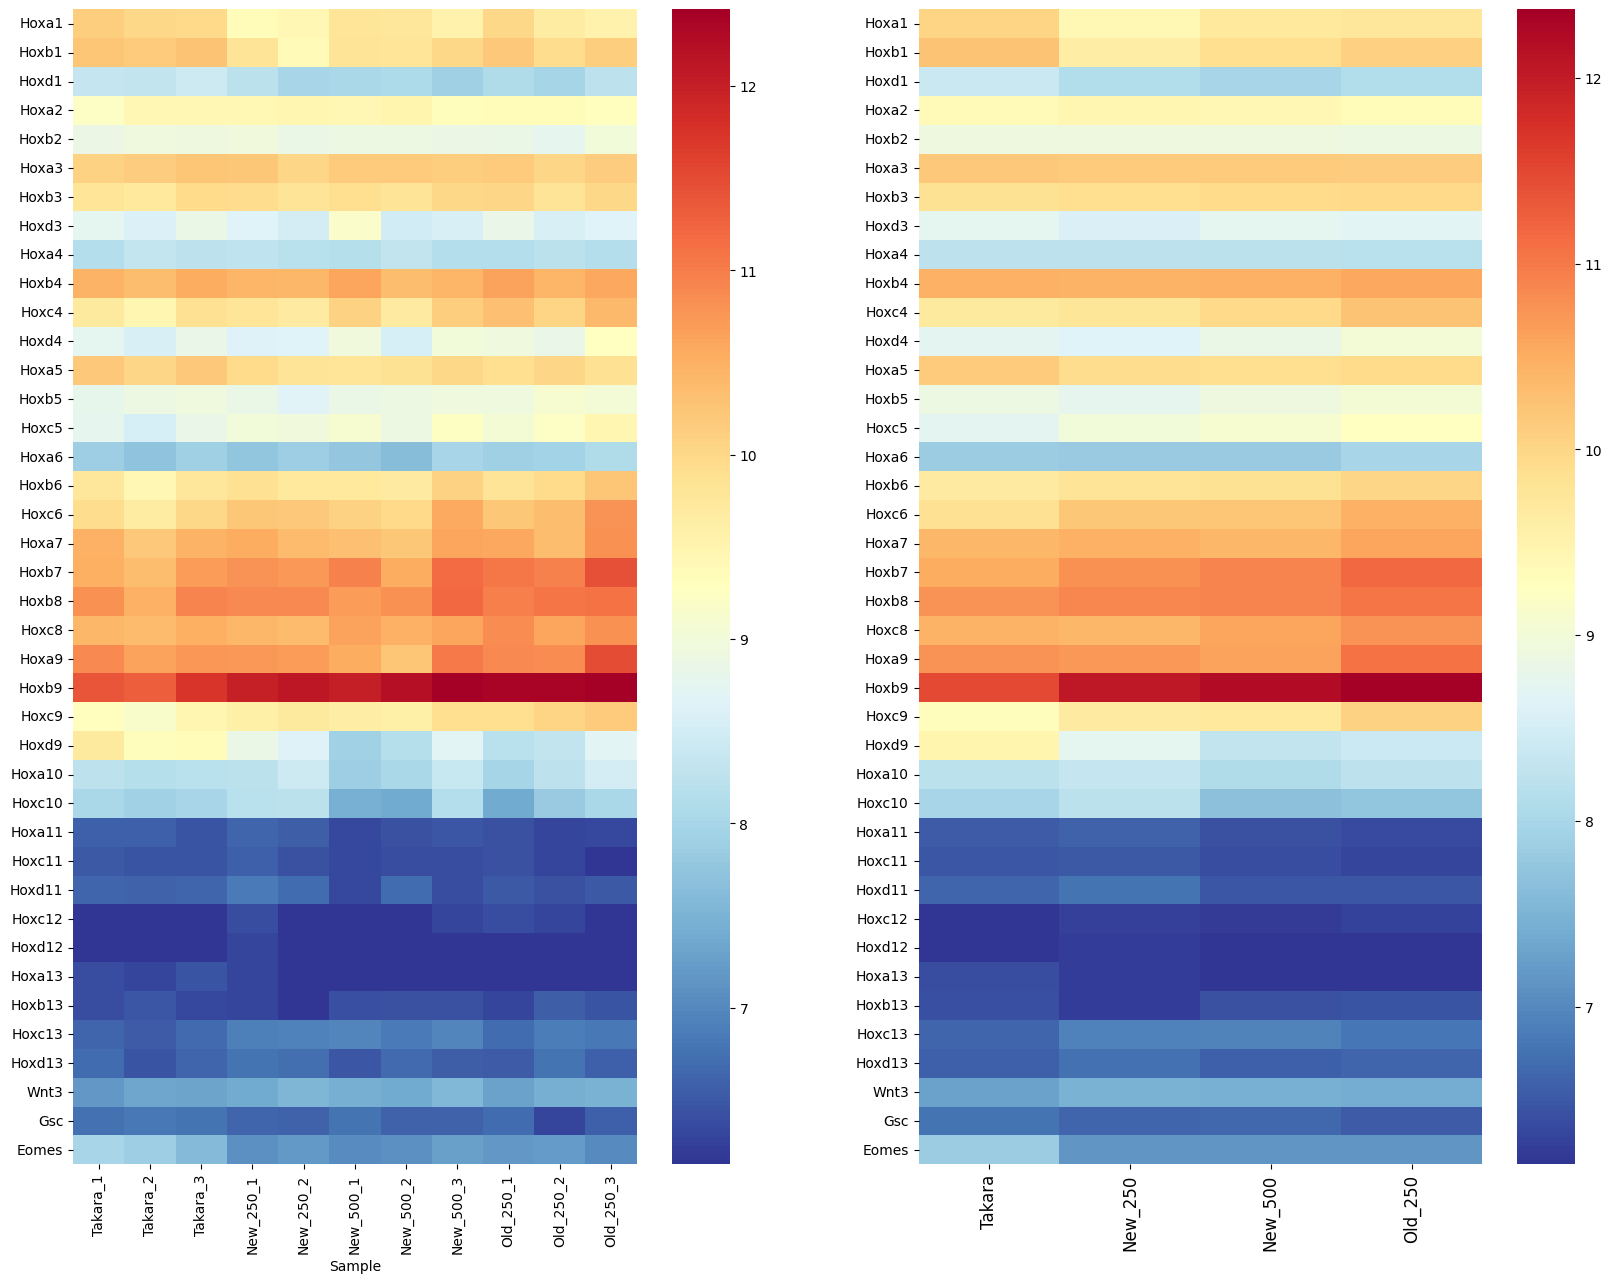

In [112]:
fig,ax=plt.subplots(1,2, figsize=(20,15))

# mean for condition
df1_mean=df1.loc[:,m3].groupby([x[:-2] for x in df1.index.values]).mean().T
df1_mean=df1_mean[['Takara','New_250','New_500','Old_250']]

# plots
sns.heatmap(df1.loc[:,m3].T, ax=ax[0],cmap='RdYlBu_r')
sns.heatmap(df1_mean, ax=ax[1],cmap='RdYlBu_r')

ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation = 90, fontsize = 12)

plt.savefig(f'results/heatmap3.{save_format}')


# CORRELATION

In [99]:
df_corr=df1_fs.T.corr()

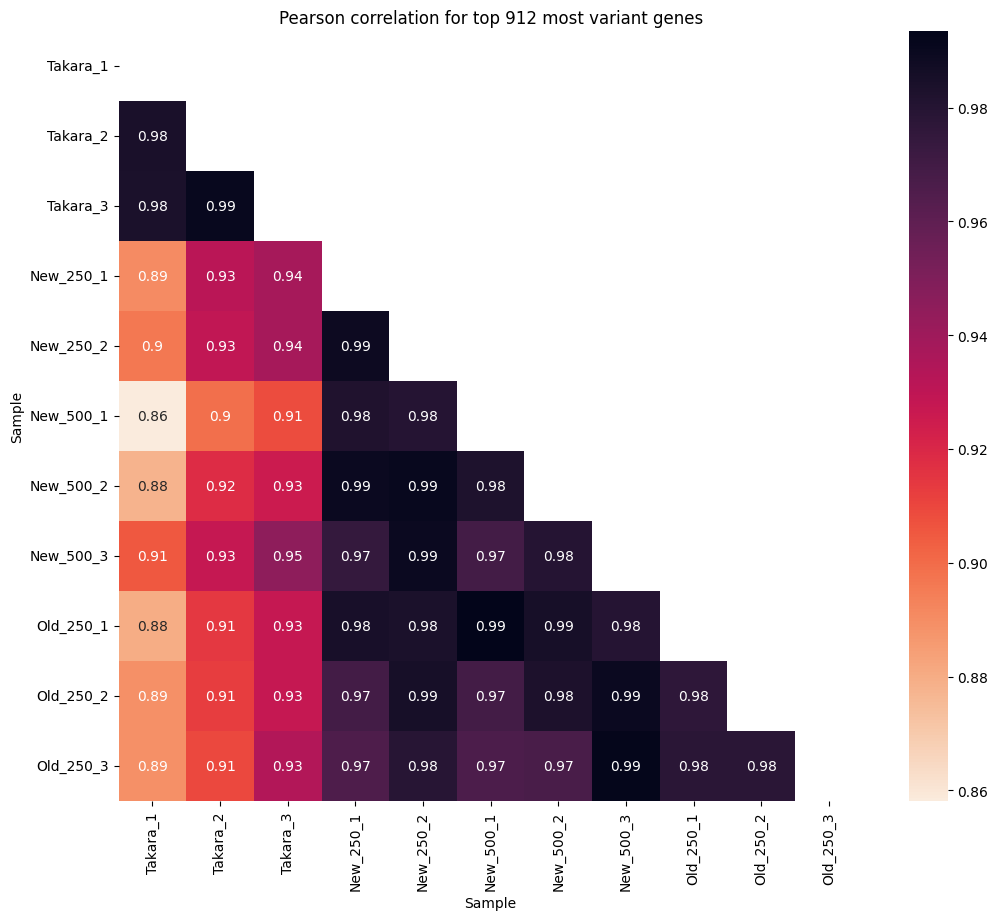

In [100]:
fig,ax=plt.subplots(1,1,figsize=(12,10))

matrix = np.triu(df_corr)

sns.heatmap(df_corr, cmap='rocket_r', annot=True,ax=ax, mask=matrix)
ax.set_title(f'Pearson correlation for top {len(l)} most variant genes')

plt.savefig(f'results/correlation_matrix.{save_format}')

# PAIR-WISE COMPARISON

In [101]:
dds.deseq2()

Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 2.75 seconds.

Fitting dispersion trend curve...
... done in 0.65 seconds.

Fitting MAP dispersions...
... done in 3.32 seconds.

Fitting LFCs...
... done in 2.44 seconds.

Replacing 0 outlier genes.



In [102]:
LFC_THRES=0.5
PADJ_THRES=0.1

In [103]:
contrasts=[('Condition','New-250','Takara'),
           ('Condition','New-500','Takara'),
           ('Condition','Old-250','Takara'),
           ('Condition','New-250','Old-250'),
           ('Condition','New-500','Old-250'),
           ('Condition','New-500','New-250')]

# Rank genes and compute DEGs

In [104]:
os.makedirs('results/pair-wise',exist_ok=True)

In [105]:
for c in contrasts:
    # set up statistical on constrast
    stat_res=DeseqStats(dds, contrast=c,quiet=True)
    # run t-test
    stat_res.summary()
    
    # results df, sorted by lfc
    res=stat_res.results_df
    res.index=df1.columns #reset genenames, they get lost
    res=res.sort_values(by='log2FoldChange', ascending=False)
    res['-log10P']=-np.log10(res.pvalue)
    res=res[res.baseMean>100]

    #DEGs subsetting
    degs=res[(abs(res['log2FoldChange'])>LFC_THRES) & (res['pvalue']<PADJ_THRES)]

    # save tables
    res.to_csv(f"results/pair-wise/ranked_{c[1]}_vs_{c[2]}.csv")
    degs.to_csv(f"results/pair-wise/degs_{c[1]}_vs_{c[2]}.csv")

Log2 fold change & Wald test p-value: Condition New-250 vs Takara
          baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
0        28.284262        0.081278  0.369944  0.219705  0.826101  0.954644
1         0.258817        1.234258  4.520046  0.273063  0.784805       NaN
2         0.359912        0.272944  3.503181  0.077913  0.937897       NaN
3         0.546879        0.273896  2.784496  0.098365  0.921643       NaN
4        88.228765        1.827326  0.638145  2.863496  0.004190  0.065259
...            ...             ...       ...       ...       ...       ...
34085     0.358236       -1.165140  4.346824 -0.268044  0.788665       NaN
34086    84.141014       -0.199218  0.232576 -0.856570  0.391682  0.782143
34087     0.408859       -1.165133  4.716068 -0.247056  0.804865       NaN
34088     0.376825       -1.165146  3.957225 -0.294435  0.768425       NaN
34089  6207.761986        0.346795  0.125122  2.771659  0.005577  0.079904

[34090 rows x 6 columns]
Log2 fol